# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [11]:
from scipy.stats import kurtosis

n_samples = 10000

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [13]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
        # Tecnología y Comunicación
        'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'AVGO', 'CRM', 'ADBE', 'NFLX',
        # Finanzas
        'JPM', 'BAC', 'V', 'MA', 'GS', 'MS', 'AXP', 'WFC',
        # Salud
        'JNJ', 'UNH', 'LLY', 'PFE', 'ABBV', 'MRK', 'TMO', 'AMGN',
        # Consumo y Retail
        'WMT', 'COST', 'PG', 'KO', 'PEP', 'NKE', 'MCD', 'SBUX',
        # Energía e Industria
        'XOM', 'CVX', 'CAT', 'GE', 'HON', 'MMM', 'UPS', 'BA',
        # Otros (Inmobiliario, Materiales, Utilities)
        'AMT', 'PLD', 'LIN', 'APD', 'NEE', 'DUK', 'INTC', 'DIS'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

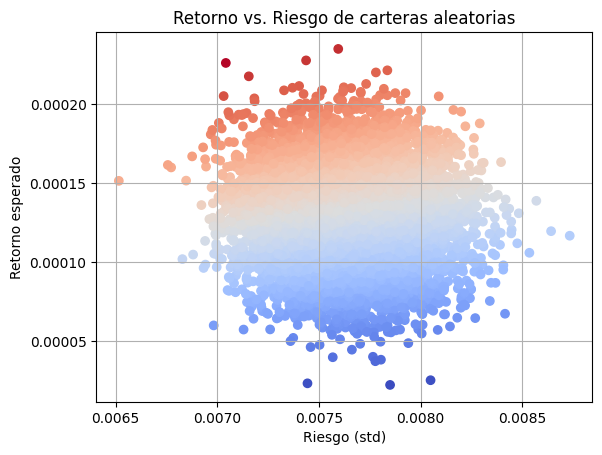

In [14]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'asset22', 'asset16', 'asset2', 'asset34', 'asset41', 'asset1', 'asset18', 'asset42', 'asset14'}
[21, 15, 1, 33, 40, 0, 17, 41, 13]


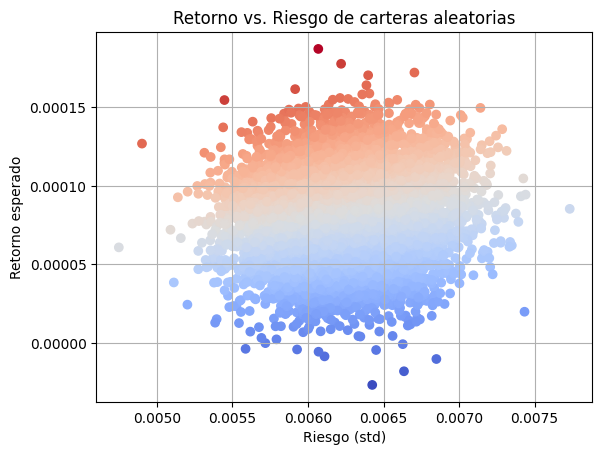

In [15]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 15):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.85) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [16]:
import cvxpy as cp

# Los assets con correlacion inferior al 85% y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

means_max_return = returns_means.max()

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

min_daily_return = 0.0004 # 10% anual

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.15, # No invertimos mas de un 15% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights @ returns_means >= min_daily_return, # Minimo un retorno del 10%
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados
]

results = []
for r_target in np.linspace(returns_means.min(), returns_means.max(), 100):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)

    problem.solve()

    if best_weights.value is not None:
        row = np.concatenate([[portfolio_returns.value], [np.sqrt(portfolio_variance.value)], best_weights.value])
        results.append(row)

columns = ["return", "volatility"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="return", ascending=False)
portfolio_results

,return,volatility,asset0,asset1,asset2,asset3,asset4,asset5,asset6,asset7,...,asset41,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,Renta Fija
86,0.000516,0.006918,1.087387e-08,-3.256270e-09,1.951056e-06,0.148300,3.604794e-06,0.149997,0.000014,0.149998,...,-2.711864e-10,0.000010,9.039186e-03,0.000012,1.253200e-06,0.000008,0.000009,0.000018,0.000009,0.000005
85,0.000501,0.006586,5.698747e-09,-1.465284e-09,5.064302e-07,0.127227,5.227384e-07,0.149998,0.000007,0.149998,...,-8.161531e-10,0.000004,7.178886e-03,0.000003,-7.934541e-08,0.000005,0.000004,0.000006,0.000003,0.040398
84,0.000487,0.006259,-3.975777e-09,2.521390e-09,-1.061020e-06,0.118873,-2.892636e-06,0.150001,-0.000008,0.150000,...,-8.315898e-10,-0.000006,2.605985e-03,-0.000009,-9.692358e-07,-0.000002,-0.000005,-0.000013,-0.000007,0.086027
83,0.000473,0.006004,-9.073649e-09,3.720444e-09,-7.724708e-07,0.063901,1.968493e-02,0.150003,-0.000012,0.150003,...,8.529801e-10,-0.000007,8.478740e-07,-0.000009,3.042560e-02,-0.000007,-0.000006,-0.000014,-0.000007,0.099997
82,0.000458,0.005837,7.792360e-09,-2.474683e-09,1.429195e-06,0.053035,4.170052e-02,0.149997,0.000013,0.149998,...,-1.019299e-09,0.000006,-4.358352e-07,0.000007,2.581510e-02,0.000008,0.000007,0.000011,0.000004,0.100001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0.000400,0.005265,-7.273333e-09,2.663674e-09,-1.022115e-06,0.040325,8.665294e-02,0.150003,-0.000011,0.150003,...,1.734573e-09,-0.000005,7.310296e-07,-0.000006,3.802611e-02,-0.000007,-0.000006,-0.000010,-0.000004,0.100000
53,0.000400,0.005265,-7.952667e-09,2.904140e-09,-1.111926e-06,0.040326,8.666239e-02,0.150003,-0.000013,0.150003,...,1.906659e-09,-0.000006,8.092257e-07,-0.000006,3.803260e-02,-0.000008,-0.000007,-0.000011,-0.000004,0.100000
54,0.000400,0.005265,-8.111879e-09,2.998406e-09,-1.164016e-06,0.040324,8.666220e-02,0.150003,-0.000013,0.150003,...,1.886204e-09,-0.000006,7.729278e-07,-0.000007,3.802260e-02,-0.000008,-0.000007,-0.000012,-0.000005,0.099999
66,0.000400,0.005265,-9.620834e-09,3.554130e-09,-1.378897e-06,0.040324,8.668204e-02,0.150004,-0.000015,0.150004,...,2.241076e-09,-0.000007,9.198262e-07,-0.000008,3.803055e-02,-0.000010,-0.000008,-0.000014,-0.000005,0.099999


In [17]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [18]:
rounded_weights = round_weights(portfolio_results.iloc[0, 2:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)

['0', '0', '0', '0.149', '0', '0.15', '0', '0.149', '0', '0', '0', '0', '0.15', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0.15', '0', '0', '0', '0', '0.038', '0', '0', '0', '0', '0', '0', '0.055', '0.15', '0', '0', '0', '0', '0', '0', '0', '0.009', '0', '0', '0', '0', '0', '0', '0']


In [19]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.000079

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.00744386041794564
